# Surrogate Assisted Nonrigid Registration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import sys
sys.path.append('../source')

from sanrr import MyMIRTK
from mydata import create_fei_db, save_files

%matplotlib inline

#### Crete a dataset with landmarks and save it

In [2]:
fei_db = create_fei_db()
save_files(fei_db,'./im/')

#### Set the framework options

In [3]:
additional_params = []
n_resolutions = 2
control_points_as_params = True
configuration_file = 'register-2d-face-landmarks.cfg'

solver = MyMIRTK(additional_params,
                 n_resolutions,
                 control_points_as_params,
                 configuration_file)

#### Find optimal number of components

In [4]:
explained_variance = .8
solver.setPCA(fei_db,explained_variance)

No. of components = 25
Explained variance ratio = 0.824093591427
No. of components = 12
Explained variance ratio = 0.730191953711
No. of components = 18
Explained variance ratio = 0.784523499463
No. of components = 21
Explained variance ratio = 0.803444907046
No. of components = 19
Explained variance ratio = 0.79112236216
No. of components = 20
Explained variance ratio = 0.797348501313
No. of components = 20
Explained variance ratio = 0.797348528685


#### Define the files, DoE samples and number of Kriging iterations

In [5]:
files = {'ref_im': './im/mean.pgm',
         'ref_vtk': './im/mean.vtk',
         'mov_im': './im/1.pgm',
         'mov_vtk': './im/1.vtk',
         'out_im': './transformed/1.pgm',
         'out_vtk': './transformed/1.vtk',
         'dofs': './dofs/b__a.dof.gz'}
samples = 11
numiter = 5

#### Solve optimal hyperparameters using Kriging for nonrigid registration 

In [6]:
np.random.seed(1)
solver.krigeRegister(files,samples,numiter)

Sampling space...
Training kriging model...
Infill iteration 1 of 5....
Infill iteration 2 of 5....
Infill iteration 3 of 5....
Infill iteration 4 of 5....
Infill iteration 5 of 5....
Predicting optimal solution...
Registering image...
Done!


#### Get optimal control point spacing for each resolution

In [7]:
solution = np.array(solver.solution)*190+10
print "Optimal control point spacing for 1st resolution is " + str(int(solution[0])) +"\n"\
      "Optimal control point spacing for 2nd resolution is " + str(int(solution[1])) +"\n"

Optimal control point spacing for 1st resolution is 63
Optimal control point spacing for 2nd resolution is 95



# Discussion

#### Visualize the reference and moving image before registration

--------------------- | Image Grid Descrption | ---------------------
--------------------- | --------------------- | ---------------------
ref_im                | ref_im + ref_vtk      | ref_im + mov_vtk
mov_im                | mov_im + mov_vtk      | mov_im + ref_vtk

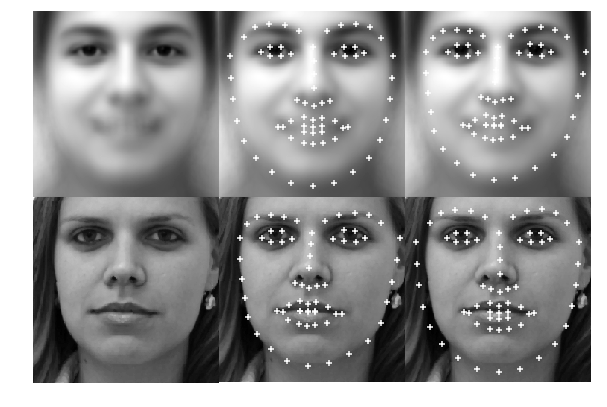

In [8]:
def plot_landmarks(figure,vtk_bool):
    plt.imshow(figure['image'],cmap='gray',origin="lower")
    if vtk_bool == True:
        plt.scatter(figure['landmarks'][:,0],figure['landmarks'][:,1],marker='+',color='w')
        plt.xlim([0,figure['image'].shape[1]])
        plt.ylim([0,figure['image'].shape[0]])
    plt.gca().invert_yaxis()
    plt.axis('off')
    
mean_face = np.mean(fei_db['images'],0)
mean_landmarks = np.mean(fei_db['landmarks'],0)

plot_files = ([mean_face,"",False],
              [mean_face,mean_landmarks,True],
              [mean_face,fei_db['landmarks'][0],True],
              [fei_db['images'][0],"",False],
              [fei_db['images'][0],fei_db['landmarks'][0],True],
              [fei_db['images'][0],mean_landmarks,True])

fig = plt.figure(figsize=(10,6.84))
fig.subplots_adjust(hspace=0, wspace=0)
for i, plot_arg in enumerate(plot_files):
    plt.subplot(2,3,i+1)
    plot_landmarks({'image': plot_arg[0],'landmarks': plot_arg[1]},plot_arg[2])

#### Visualize optimally registered image

--------------------- | Image Grid Descrption | ---------------------
--------------------- | --------------------- | ---------------------
ref_im                | ref_im + ref_vtk      | ref_im + out_vtk
out_im                | out_im + out_vtk      | out_im + ref_vtk

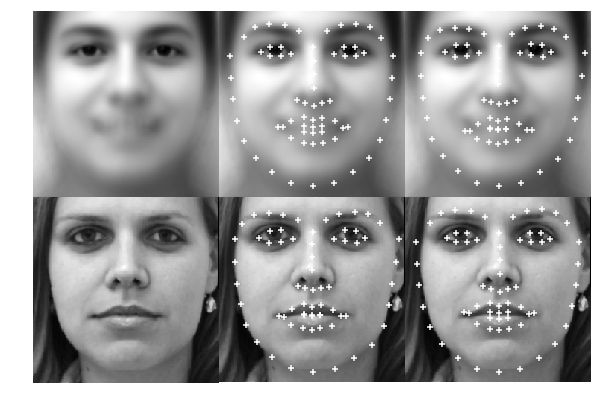

In [9]:
registered_image = np.array(Image.open(files['out_im']))
registered_vtk = []
with open(files['out_vtk'], 'rt') as f_vtk:
    vtk_list = f_vtk.readlines()
    for i in range(5,len(vtk_list)):
        registered_vtk.append(np.array(vtk_list[i].split(),dtype=np.float64))
registered_vtk = np.array(registered_vtk)
registered_vtk[:,0] += registered_image.shape[0]/2.
registered_vtk[:,1] += registered_image.shape[1]/2.

plot_files = ([mean_face,"",False],
              [mean_face,mean_landmarks,True],
              [mean_face,registered_vtk,True],
              [registered_image,"",False],
              [registered_image,registered_vtk,True],
              [registered_image,mean_landmarks,True])

fig = plt.figure(figsize=(10,6.84))
fig.subplots_adjust(hspace=0, wspace=0)
for i, plot_arg in enumerate(plot_files):
    plt.subplot(2,3,i+1)
    plot_landmarks({'image': plot_arg[0],'landmarks': plot_arg[1]},plot_arg[2])

#### Visualize Kriging seach space for hyperparameter optimization (control points)

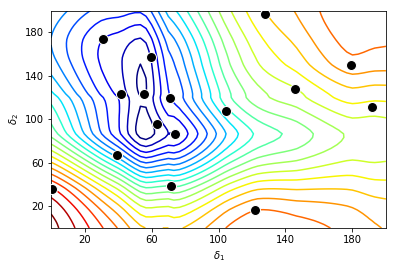

In [10]:
def kriging_plot(k):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    X,Y,Z,Ze,spx,spy=k.kdata
    plt.contour(X,Y,Z,20, cmap='jet')
    plt.scatter(spx,spy,c=[0,0,0],edgecolors='white',s=100,zorder=1000)
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_xlabel(r'$\delta_1$')
    ax.set_ylabel(r'$\delta_2$')
    ticks = np.array([.1,.3,.5,.7,.9])
    real_ticks = np.array([20,60,100,140,180])
    plt.xticks(ticks)
    ax.set_xticklabels(real_ticks)
    plt.yticks(ticks)
    ax.set_yticklabels(real_ticks)
    
kriging_plot(solver)